In [2]:
import sys
import os
import re

In [3]:
DEBUG_FILE = "debug.log"
PATH_FILE = "path"
PERFORMANCE_FILE = "performance.log"

In [4]:
state_path = "/Users/srinidhi/Local/dmckruns/run3/epaxos/state"

In [30]:
class Run:
    def __init__(self):
        self.id = None
        self.states = []
        self.path = []
        self.execution_time = 0
        self.duplicated = False

class State:
    def __init__(self):
        self.events = []
        self.next_event = None
    
    def empty(self):
        return len(self.events) == 0 and self.next_event is None

class Event:
    def __init__(self):
        self.id = ""
        self.msg = ""
        self.msgType = ""
        self.sender = ""
        self.recv = ""

class CommitMsg:
    def __init__(self):
        self.leader = ""
        self.replica = ""
        self.instance = ""
        self.deps = []

In [31]:
def remove_prefix(string, prefix):
    if string.startswith(prefix):
        return string[len(prefix):]
    return string

In [32]:
def parse_debug(file):
    states = []
    state_lines = []
    for line in file.readlines():
        line = line.strip()
        if line == "Update from Target System:":
            if len(state_lines) != 0:
                state = parse_state(state_lines)
                if not state.empty():
                    states.append(state)
            state_lines = []
        state_lines.append(line)
    return states

In [33]:
def parse_state(lines):
    new_state = State()
    for line in lines:
        if line.startswith("Next Event:"):
            start = line.find("packetsend")
            new_state.next_event = parse_event(line[start:])
        elif line.find("packetsend") != -1:
            start = line.find("packetsend")
            new_state.events.append(parse_event(line[start:]))
    return new_state

In [34]:
def parse_event(line):
    event = Event()
    p = re.match(r'(?P<header>packetsend)\s(?P<tid>tid=-?[0-9]+)\s(?P<event>Event=\{.*\})\s.*', line)
    e = None
    msg = None
    if p is not None:
        e = re.match(r'\{(?P<msg>msg=&.*\{.*\},)\s(?P<others>.*)\}', remove_prefix(p.group('event'), "Event="))
    if e is not None:
        for props in e.group('others').split(','):
            props = props.strip()
            [key, value] = props.split('=')
            if key == "verb":
                event.msgType = value
            if key == "sendNode":
                event.sender = value
            if key == "recvNode":
                event.recv = value
            if key == "eventId":
                event.id = value
        if (event.msgType == "Commit" or event.msgType == "CommitShort"):
            event.msg = parse_commitmsg(remove_prefix(e.group('msg'),'msg=&'))
        else:
            event.msg = remove_prefix(e.group('msg'),'msg=&')
    return event

In [35]:
def parse_commitmsg(msg):
    r = re.match(r'(?P<name>\w+\.\w+)\{(?P<fields>.*)\}', msg)
    if r is not None:
        fields = r.group('fields')
        c = CommitMsg()
        l_re = re.search(r'LeaderId:(?P<leader>\d+)', fields)
        if l_re is not None:
            c.leader = l_re.group('leader')
        r_re = re.search(r'Replica:(?P<replica>\d+)', fields)
        if r_re is not None:
            c.replica = r_re.group('replica')
        i_re = re.search(r'Instance:(?P<instance>\d+)', fields)
        if i_re is not None:
            c.instance = i_re.group('instance')
        d_re = re.search(r'Deps:\[5\]int32\{(?P<deps>.*)\}', fields)
        if d_re is not None:
            for d in d_re.group('deps').split(','):
                c.deps.append(int(d.strip()))
        return c
    return None

In [36]:
def conflict(states):
    commits = []
    for state in states:
        for event in state.events:
            if event.msgType == "Commit" or event.msgType == "CommitShort":
                commits.append(event.msg)

    instances = {}
    for c in commits:
        if c.replica not in instances:
            instances[c.replica] = {}
        if c.instance not in instances[c.replica]:
            instances[c.replica][c.instance] = c.deps
        if c.deps != instances[c.replica][c.instance]:
            return True
    return False

In [37]:
e = parse_event("packetsend tid=-1743781515 Event={msg=&epaxosproto.CommitShort{LeaderId:0, Replica:0, Instance:0, Count:1, Seq:1, Deps:[5]int32{-1, 0, -1, 0, 0}}, eventId=12, recvNode=1, verb=CommitShort, hashId=373, sendNode=0} [[0, 4, 0, 0], [4, 0, 0, 0], [0, 0, 0, 0]]")

In [38]:
e.msgType

'CommitShort'

In [39]:
def parse_path(file):
    events = []
    duplicated = False
    for line in file.readlines():
        if line.startswith("packetsend"):
            events.append(parse_event(line.strip()))
        elif line.strip() == "Duplicated path.":
            duplicated = True
    return events, duplicated

In [43]:
def parse_performance(file):
    text = file.read()
    m = re.search(r'total-execution-path-time=(?P<time>\d+)ms', text)
    if m is not None:
        return int(m.group('time'))
    return 0

In [69]:
def parse_run(d):
    if os.path.isdir(d):
        run = Run()
        with open(os.path.join(d,DEBUG_FILE)) as f:
            states = parse_debug(f)
            run.states = states
        with open(os.path.join(d,PATH_FILE)) as f:
            path, duplicated = parse_path(f)
            run.path = path
            run.duplicated = duplicated
        with open(os.path.join(d,PERFORMANCE_FILE)) as f:
            execution_time = parse_performance(f)
            run.execution_time = execution_time
        return run

In [94]:
def collect_runs(path):
    runs = []
    if os.path.isdir(path):
        for d in os.listdir(path):
            run = parse_run(os.path.join(path, d))
            run.id = int(d)
            runs.append(run)
    return runs

In [95]:
runs = collect_runs(state_path)

In [96]:
nonempty_runs = list(filter(lambda r: len(r.states) != 0, runs))
print("Empty runs:", len(runs) - len(nonempty_runs))

duplicated = 0
for r in nonempty_runs:
    if r.duplicated:
        duplicated += 1
print("Duplicated runs:", duplicated)

Empty runs: 1665
Duplicated runs: 290


In [97]:
conflict_runs = []
for r in nonempty_runs:
    if conflict(r.states):
        conflict_runs.append(r.id)
print("Runs with the bug:",conflict_runs)

Runs with the bug: []


In [98]:
import numpy

In [119]:
stats = []
for r in nonempty_runs:
    stats.append([r.id, len(r.path), r.execution_time])
stats = numpy.array(stats)

In [120]:
print("Longest path length:", stats[:,1].max())

Longest path length: 20


In [121]:
import matplotlib.pyplot as plt

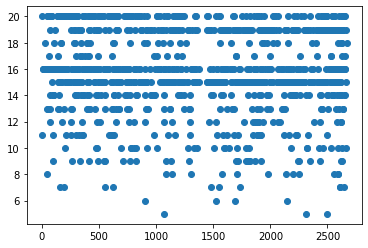

In [122]:
plt.scatter(stats[:,0],stats[:,1])

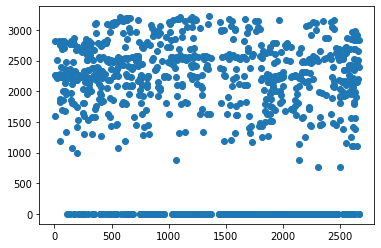

In [123]:
plt.scatter(stats[:,0], stats[:,2])